In [ ]:
# !pip install qiskit --quiet
# !pip install qiskit-machine-learning --quiet
# !pip install pylatexenc --quiet

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import Tensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Module, Linear
from torchvision import datasets, transforms
import torch.nn.functional as F

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit import QuantumCircuit, Aer, transpile
from qiskit_machine_learning.neural_networks import CircuitQNN,TwoLayerQNN, OpflowQNN
from qiskit.opflow import AerPauliExpectation
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.opflow import ListOp
from qiskit.opflow import PauliSumOp, StateFn

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
device = get_default_device()
device

device(type='cpu')

In [4]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
def one_qubit_unitary(thetas):
    qc = QuantumCircuit(1)
    qc.rx(thetas[0], 0)
    qc.ry(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc

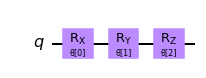

In [6]:
thetas = ParameterVector('θ', length=3)
circuit = one_qubit_unitary(thetas)
circuit.draw('mpl')

In [61]:
class MnistDataModule():
    def __init__(self, n_features = 2):
        super().__init__()
        self.batch_size = 16
        self.num_workers = 4
        
        self.dims = (1,28,28)
        self.output_dims = (1,)
        self.mapping = list(range(2))
        self.classes = [3,6]
        
        self.on_gpu = torch.cuda.is_available()
        
    def config(self):
        """Return important settings of the dataset, which will be passed to instantiate models."""
        return {"input_dims": self.dims, "output_dims": self.output_dims, "mapping": self.mapping}
    
    def prepare_data(self):
        data_train = datasets.MNIST(root="./data", 
                                 train=True, 
                                 download=True, 
                                 transform=transforms.Compose([transforms.ToTensor()])
                    )
        n_samples = 70
        
        # Filter out labels (originally 0-9), leaving only labels 0 and 1
        idx = np.append(
            np.where(data_train.targets == self.classes[0])[0][:n_samples], 
            np.where(data_train.targets == self.classes[1])[0][:n_samples]
        )
        
        self.x_train = data_train.data[idx].numpy().reshape(-1,784)
        self.y_train = data_train.targets[idx].numpy()
        self.y_train = self.y_train == self.classes[0]
        
        data_test = datasets.MNIST(root="./data", 
                                 train=False, 
                                 download=True, 
                                 transform=transforms.Compose([transforms.ToTensor()]))
        
        n_samples = 32
        # Filter out labels (originally 0-9), leaving only labels 0 and 1
        idx = np.append(
            np.where(data_train.targets == self.classes[0])[0][:n_samples], 
            np.where(data_train.targets == self.classes[1])[0][:n_samples]
        )
        
        self.x_test = data_test.data[idx].numpy().reshape(-1,784)
        self.y_test = data_test.targets[idx].numpy()
        self.y_test = self.y_test == self.classes[0]
    
    def setup(self, stage=None):
        
        scaler = MinMaxScaler((-np.pi, np.pi))
        
        self.x_train = scaler.fit_transform(self.x_train)
        self.x_test = scaler.fit_transform(self.x_test)
        
        resize = transforms.Resize((10,10))
        orig_shape = (-1,1,28,28)
        new_shape = (-1,1,10,10)  
        
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, 
                                                                              self.y_train, 
                                                                              test_size=0.2, 
                                                                              random_state=42)                           
        
        self.x_train = self.x_train.reshape(orig_shape)
        self.x_train = resize(Tensor(self.x_train))
        self.y_train = Tensor(self.y_train).type(LongTensor)
        
        self.x_val = self.x_val.reshape(orig_shape)
        self.x_val = resize(Tensor(self.x_val))
        self.y_val = Tensor(self.y_val).type(LongTensor)
        
        self.x_test = self.x_test.reshape(orig_shape)
        self.x_test = resize(Tensor(self.x_test))
        self.y_test = Tensor(self.y_test).type(LongTensor)
        
        self.dims = new_shape[1:]
        
        self.data_train = TensorDataset(self.x_train, self.y_train)
        self.data_val = TensorDataset(self.x_val, self.y_val)
        self.data_test = TensorDataset(self.x_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            shuffle=True,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory = self.on_gpu
        )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory = self.on_gpu
        )

    def test_dataloader(self):
        return DataLoader(
            self.data_test,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory = self.on_gpu
        )
    def __repr__(self):
        basic = f"Mnist Dataset\nNum classes: {len(self.mapping)}\nMapping: {self.mapping}\nDims: {self.dims}\n"
        x, y = next(iter(self.train_dataloader()))
        data = (
            f"Train/val/test sizes: {len(self.data_train)}, {len(self.data_val)}, {len(self.data_test)}\n"
            f"Batch x stats: {(x.shape, x.dtype, x.min(), x.mean(), x.std(), x.max())}\n"
            f"Batch y stats: {(y.shape, y.dtype, y.min(), y.max())}\n"
        )
        return basic + data

In [62]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [63]:
data = MnistDataModule()
data.prepare_data()
data.setup()

In [64]:
data

Mnist Dataset
Num classes: 2
Mapping: [0, 1]
Dims: (1, 10, 10)
Train/val/test sizes: 112, 28, 64
Batch x stats: (torch.Size([16, 1, 10, 10]), torch.float32, tensor(-3.1416), tensor(-2.2047), tensor(1.9385), tensor(3.1364))
Batch y stats: (torch.Size([16]), torch.int64, tensor(0), tensor(1))

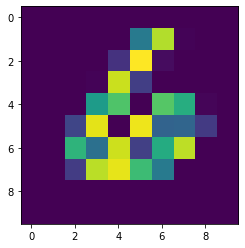

In [65]:
plt.imshow(data.data_train[3][0][0])

In [66]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [197]:
class QConvBlock(Module):
    def __init__(self, kernel_size=2,strides=1):
        
        super().__init__()
        self.kernel_size = kernel_size
        self.strides = strides
        self.qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        self.filter_size = kernel_size*kernel_size
        self.qcnn = None
        
    def build(self,input_shape):
        s = self.strides
        k = self.kernel_size
        f = self.filter_size
        
        self.pad = (3 - (f % 3)) % 3
        
        self.in_thetas = []
        self.weights = []
        self.bias =  []
        
        operators = []
        rotations = (f + self.pad)//3
        
        n = (input_shape[2] - k)//s + 1
        m = (input_shape[3] - k)//s + 1
        
        rotations = (f+self.pad)//3
        observable = PauliSumOp.from_list([("Z" * 1, 1)])
        
        for i in range(n):
            for j in range(m):
                circuit= QuantumCircuit(1)
                for k in range(rotations):
                    suffix = str(i)+str(j)+str(k)
                    
                    x = ParameterVector('x'+suffix, length=3)
                    w = ParameterVector('w'+suffix, length=3)
                    b = ParameterVector('b'+suffix, length=3)
                    
                    parameters = [w[i]*x[i] + b[i] for i in range(3)]
                    circuit.compose(one_qubit_unitary(parameters), [0], inplace=True)
                    
                    self.in_thetas += list(x)
                    self.weights += list(w)
                    self.bias += list(b)
                    
                operators.append(~StateFn(observable) @ StateFn(circuit)) 
        
        self.operators = ListOp(operators)
        
        # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
        self.qcnn = OpflowQNN(self.operators,
                              input_params= self.in_thetas,
                              weight_params= self.weights + self.bias,
                              input_gradients=True,
                              exp_val = AerPauliExpectation(),
                              quantum_instance=self.qi_sv)
        self.model_circuit = TorchConnector(self.qcnn)
        
    def forward(self, x):
        s = self.strides
        k = self.kernel_size
        
        n = (x.shape[2] - k)//s + 1
        m = (x.shape[3] - k)//s + 1
        
        if self.qcnn is None:
            self.build(x.shape)
        
        sub_images = []
        padder = torch.nn.ZeroPad2d((0,self.pad))
        for i in range(n):
            for j in range(m):
                sub_images.append(padder(torch.flatten(x[:, 0, i*s:i*s+k, j*s:j*s+k],1)))
        
        sub_images = torch.cat(sub_images,1)
        
        out = torch.reshape(self.model_circuit(sub_images), (-1,1,n,m))
        return out

In [198]:
class QCNN(Module):
    def __init__(self,data_config):
        super().__init__()

        input_dims = data_config["input_dims"]
        num_classes = len(data_config["mapping"])
    
        self.qconv = QConvBlock(3,1)
        self.dense = Linear(64,1)
        
    def forward(self, x):
        x = F.relu(self.qconv(x))
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.dense(x))
        return torch.cat((x, 1 - x), -1)
    
    def training_step(self, batch): 
        x, y = batch
        logits = self(x)
        loss = torch.nn.NLLLoss()(logits, y)
        acc = accuracy(logits, y)
        return {'train_loss': loss, 'train_acc': acc}

    def validation_step(self, batch): 
        x, y = batch
        logits = self(x)
        loss = torch.nn.NLLLoss()(logits, y)
        acc = accuracy(logits, y)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

In [199]:
def evaluate(model, val_dataloader):
    outputs = [model.validation_step(batch) for batch in val_dataloader]
    return model.validation_epoch_end(outputs)

In [200]:
def fit(epochs, lr, model, train_dataloader, val_dataloader,):
    history = {
        'train_acc':[],
        'train_loss':[],
        'val_acc':[np.nan],
        'val_loss':[np.nan]
    }
    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=1, min_lr=1e-6)
    for epoch in range(epochs):
        # Training 
        with tqdm(train_dataloader, unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                optimizer.zero_grad(set_to_none=True)
                output = model.training_step(batch)
                loss , acc = output['train_loss'], output['train_acc']
                
                history['train_loss'].append(loss.item())
                history['train_acc'].append(acc.item())
                
                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item(), 
                                   acc=acc.item(),
                                   val_loss= history['val_loss'][-1], 
                                   val_acc =history['val_acc'][-1])
                print()
                
        # Validation
        result = evaluate(model, val_dataloader)
        
        val_loss = result['val_loss']
        val_acc = result['val_acc']
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_loss)
        
    return history

In [201]:
train_dataloader = DeviceDataLoader(data.train_dataloader(), device)
val_dataloader = DeviceDataLoader(data.val_dataloader(), device)

In [202]:
model = QCNN(data.config())
to_device(model,device)

QCNN(
  (qconv): QConvBlock()
  (dense): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
history = fit(5, 0.001, model, train_dataloader, val_dataloader)

Epoch 0:   0%|                                                                              | 0/7 [00:00<?, ?batch/s]

In [183]:
train_losses = history['train_loss']
val_losses = history['val_loss']
train_accs = history['train_acc']
val_accs = history['val_acc']

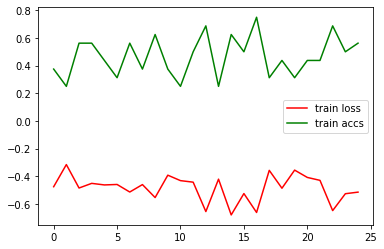

In [184]:
plt.plot(train_losses, color='r', label='train loss')
plt.plot(train_accs, color='g', label='train accs')
plt.legend()

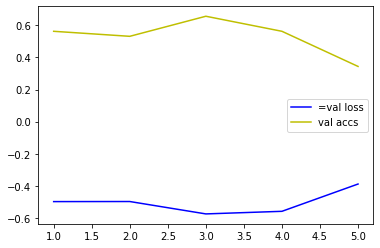

In [185]:
plt.plot(val_losses, color='b', label='=val loss')
plt.plot(val_accs, color='y', label='val accs')
plt.legend()

In [186]:
torch.save(model.state_dict(), "model.pt")

In [187]:
model = QCNN(data.config())
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [188]:
test_dataloader = DeviceDataLoader(data.test_dataloader(), device)
to_device(model, device)

QCNN(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (qconv): QConvBlock()
  (dense): Linear(in_features=4, out_features=1, bias=True)
)

In [189]:
result = evaluate(model, test_dataloader)
print('test_loss: {:.4f}'.format(result['val_loss']) )
print('test_acc: {:.4f}'.format(result['val_acc']))

torch.Size([16, 1, 2, 2])
torch.Size([16, 1, 2, 2])
torch.Size([16, 1, 2, 2])
torch.Size([16, 1, 2, 2])
test_loss: -0.3315
test_acc: 0.1094
